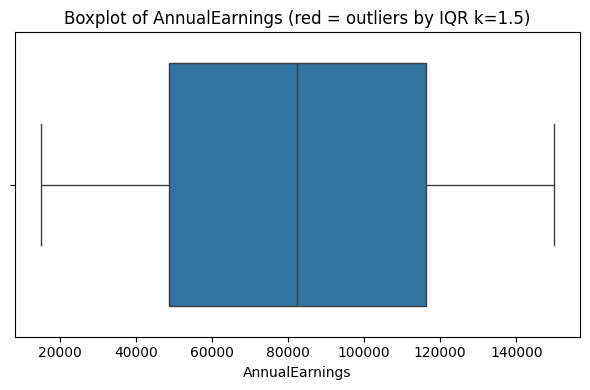

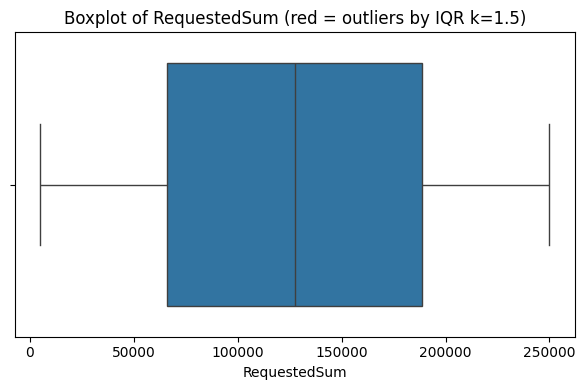

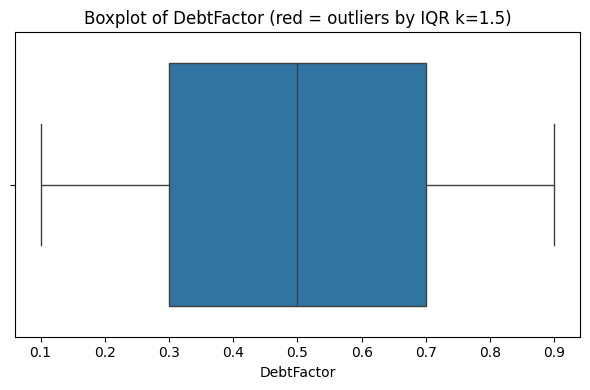

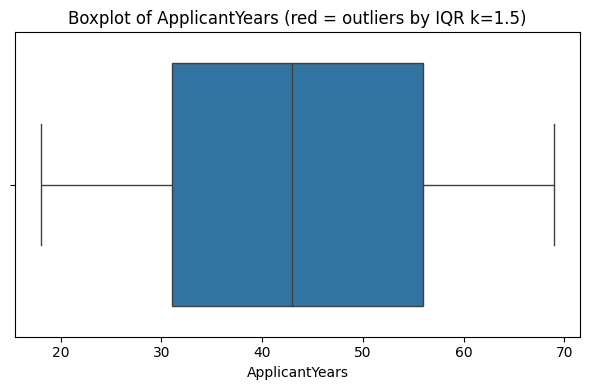

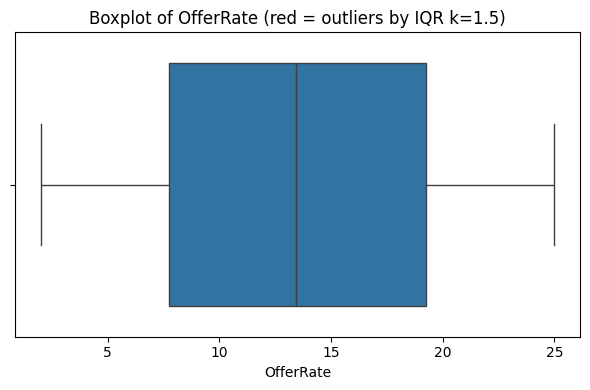

All continuous numeric columns scaled successfully.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df=pd.read_csv('/home/shantanu/Desktop/SEM 5/ML/Financial Risk/train_updated.csv')
test_df=pd.read_csv('/home/shantanu/Desktop/SEM 5/ML/Financial Risk/test_updated.csv')

# idhar duplicates hata diye if any
train_df=train_df.drop_duplicates()
test_df=test_df.drop_duplicates()

# idhar ProfileID column hata diya coz its useless for modeling
train_df = train_df.drop(columns=["ProfileID"])
test_df = test_df.drop(columns=["ProfileID"])

# Converting binary categorical columns to nuerical bool values as 1 or 0
binary_cols = ["OwnsProperty", "FamilyObligation", "JointApplicant"]

for col in binary_cols:
    train_df[col] = train_df[col].map({"Yes": 1, "No": 0})
    test_df[col] = test_df[col].map({"Yes": 1, "No": 0})

# One-hot encoding for multi-class categorical columns and this creates new columns har ek category ke liye
cat_cols = ["QualificationLevel", "WorkCategory", "RelationshipStatus", "FundUseCase"]

train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)


# --------------------------
# OUTLIER FINDING (IQR) HELPERS
# --------------------------

def iqr_bounds(series, k=1.5):
    """
    Return (lower_bound, upper_bound) for a pandas Series using IQR * k (default 1.5).
    This is the same rule used by boxplots.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

def find_outliers_iqr(df, column, k=1.5):
    """
    Identify outliers in df[column] using IQR method.
    Returns a DataFrame of the outlier rows (preserves all columns), and the bounds.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame")

    lower, upper = iqr_bounds(df[column].dropna(), k=k)
    mask_outlier = (df[column] < lower) | (df[column] > upper)
    outliers_df = df.loc[mask_outlier].copy()
    return outliers_df, lower, upper

def report_outliers(df, columns, k=1.5, show_sample=5):
    """
    For each column in `columns`, prints number of outliers, fraction of rows,
    and shows the first `show_sample` outlier rows (if any).
    Also returns a dict with column -> (outliers_df, lower, upper).
    """
    results = {}
    n = len(df)
    for col in columns:
        if col not in df.columns:
            #print(f"[WARN] Column '{col}' not found — skipping.")
            continue
        out_df, lb, ub = find_outliers_iqr(df, col, k=k)
        count = len(out_df)
        frac = count / n
        #print(f"Column: {col:15} | Outliers: {count:6} | Fraction: {frac:.4f} | bounds: ({lb:.3g}, {ub:.3g})")
        if count > 0:
            display_sample = out_df[[col]].head(show_sample)
            #print("  sample outlier values:")
            #print(display_sample.to_string(index=False))
        results[col] = (out_df, lb, ub)
    return results

def plot_box_with_outliers(df, column, k=1.5, figsize=(6,4)):
    """
    Draw a boxplot for `column` and overlay the outliers as red points.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame")
    out_df, lb, ub = find_outliers_iqr(df, column, k=k)

    plt.figure(figsize=figsize)
    sns.boxplot(x=df[column], orient='h')
    if len(out_df) > 0:
        # overlay outliers
        sns.stripplot(x=out_df[column], orient='h', color='red', size=4, jitter=False)
    plt.title(f"Boxplot of {column} (red = outliers by IQR k={k})")
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()

# --------------------------
# USAGE: specify the columns you asked for
# --------------------------

cols_to_check = ["AnnualEarnings", "RequestedSum", "DebtFactor", "ApplicantYears", "OfferRate"]

# 1) Print a quick report (how many outliers and bounds)
outlier_results_train = report_outliers(train_df, cols_to_check, k=1.5, show_sample=5)

# 2) Plot boxplots with outliers highlighted for each column (optional)
for col in cols_to_check:
    plot_box_with_outliers(train_df, col, k=1.5)

# 3) If you want the actual outlier rows for a single column:
# outliers_for_requested_sum, lower, upper = outlier_results_train["RequestedSum"]
# outliers_for_requested_sum.head()



#standardization and equalization

from sklearn.preprocessing import StandardScaler

# ALL continuous numerical columns (exclude binary + one-hot)
num_cols = [
    "ApplicantYears", "AnnualEarnings", "RequestedSum", "TrustMetric",
    "WorkDuration", "ActiveAccounts", "OfferRate", "RepayPeriod", "DebtFactor"
]

scaler = StandardScaler()

train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

print("All continuous numeric columns scaled successfully.")



